# Documentation

# Sample Notebook To Build a Model and Make Predictions with the Titanic Dataset from Kaggle

Table of Contents

0. [Params](#Params)
1. [Acquisitor and Cleaner](#Acquisitor-and-Cleaner)
2. [Training Preparator](#Training-Preparator)
3. [Trainer](#Trainer)
4. [Metrics Evaluator](#Metrics-Evaluator)
5. [Prediction Preparator](#Prediction-Preparator)
6. [Predictor](#Predictor)
7. [Feedback](#Feedback)
8. [Sample Application](#Sample-Application)

# Params

In [2]:
# puts this params in engine.params file to be used by dryrun and executor as default params
# use a full grid over all parameters
params = {
    "svm": [
        {"C": [1, 10, 100], "gamma": [0.01, 0.001], "kernel": ["linear"]},
        {"C": [1, 10, 100],"gamma": [0.01, 0.001],"kernel": ["rbf"]}
    ],
    "rf": {
        "max_depth": [3],
        "random_state": [0],
        "min_samples_split": [2],
        "min_samples_leaf": [1],
        "n_estimators": [20],
        "bootstrap": [True, False],
        "criterion": ["gini", "entropy"]
    },
    "pred_cols": ["Age", "Pclass", "Sex", "Fare"],
    "dep_var": "Survived"
}

In [3]:
from marvin_python_toolbox.common.data import MarvinData
import pandas as pd

train_df = pd.read_csv(MarvinData.download_file("https://s3.amazonaws.com/marvin-engines-data/titanic/train.csv"))
test_df = pd.read_csv(MarvinData.download_file("https://s3.amazonaws.com/marvin-engines-data/titanic/test.csv"))

print ("{} samples to train with {} features...".format(train_df.shape[0], train_df.shape[1]))
print ("{} samples to test...".format(test_df.shape[0]))

marvin_initial_dataset = {
    'train': train_df,
    'test': test_df
}

891 samples to train with 12 features...
418 samples to test...


# Training Preparator

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split, cross_val_score, GridSearchCV

train_no_na = marvin_initial_dataset['train'][params["pred_cols"] + [params["dep_var"]]].dropna()

print("Length: {}".format(len(train_no_na)))

# Feature Engineering
data_X = train_no_na[params["pred_cols"]]
data_X.loc[:, 'Sex'] = data_X.loc[:, 'Sex'].map({'male': 1, 'female': 0})
data_y = train_no_na[params["dep_var"]]

# Prepare for Stratified Shuffle Split
sss = StratifiedShuffleSplit(n_splits=5, test_size=.6, random_state=0)
sss.get_n_splits(data_X, data_y)

# Get Test Dataset
test_no_na = marvin_initial_dataset['test'][params["pred_cols"]].dropna()

print("Length: {}".format(len(test_no_na)))

# Feature Engineering
test_X = test_no_na[params["pred_cols"]]
test_X.loc[:, 'Sex'] = test_X.loc[:, 'Sex'].map({'male': 1, 'female': 0})

marvin_dataset = {
    'X_train': data_X,
    'y_train': data_y,
    'X_test': test_X,
    'sss': sss
}

print ("Preparation is Done!!!!")

Length: 714
Length: 331
Preparation is Done!!!!


/home/vagrant/.virtualenvs/titanic-engine-env/local/lib/python2.7/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


# Trainer

In [5]:
from sklearn import svm, neighbors, tree
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, scale
from sklearn.linear_model import LogisticRegression

print("\n\nStarting grid search using SVM!")

# Create a classifier with the parameter candidates
svm_grid = GridSearchCV(estimator=svm.SVC(), param_grid=params["svm"], cv=marvin_dataset["sss"], n_jobs=-1)

# Train the classifier on training data
svm_grid.fit(
    marvin_dataset['X_train'],
    marvin_dataset['y_train']
)

print("Model Type: SVM\n{}".format(svm_grid.best_estimator_.get_params()))
print("Accuracy Score: {}%".format(round(svm_grid.best_score_,4)))

print("\n\nStarting grid search using RandomForestClassifier!")

# run grid search
rf_grid = GridSearchCV(estimator=RandomForestClassifier(), param_grid=params["rf"], cv=marvin_dataset["sss"])
rf_grid.fit(
    marvin_dataset['X_train'],
    marvin_dataset['y_train']
)

print("Model Type: RF\n{}".format(rf_grid.best_estimator_.get_params()))
print("Accuracy Score: {}%".format(round(rf_grid.best_score_,4)))

marvin_model = {
    'svm': svm_grid,
    'rf': rf_grid
}



Starting grid search using SVM!
Model Type: SVM
{'kernel': 'linear', 'C': 10, 'verbose': False, 'probability': False, 'degree': 3, 'shrinking': True, 'max_iter': -1, 'decision_function_shape': None, 'random_state': None, 'tol': 0.001, 'cache_size': 200, 'coef0': 0.0, 'gamma': 0.01, 'class_weight': None}
Accuracy Score: 0.78%


Starting grid search using RandomForestClassifier!
Model Type: RF
{'warm_start': False, 'oob_score': False, 'n_jobs': 1, 'verbose': 0, 'max_leaf_nodes': None, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 20, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'criterion': 'entropy', 'random_state': 0, 'min_impurity_split': 1e-07, 'max_features': 'auto', 'max_depth': 3, 'class_weight': None}
Accuracy Score: 0.7925%


# Metrics Evaluation

In [6]:
from sklearn import metrics
import numpy as np

all_metrics = {}

_model = marvin_model
for model_type, fitted_model in _model.iteritems():
    
    y_predicted = fitted_model.predict(marvin_dataset['X_train'])
    
    all_metrics[model_type] = {}
    all_metrics[model_type]["report"] = metrics.classification_report(y_predicted, marvin_dataset['y_train'])
    all_metrics[model_type]["confusion_matrix"] = metrics.confusion_matrix(y_predicted, marvin_dataset['y_train'])                                                               
    
    # Print the classification report of `y_test` and `predicted`
    print("Classification Report:\n")
    print(all_metrics[model_type]["report"])
    
    # Print the confusion matrix
    print("Confusion Matrix:\n")
    print(all_metrics[model_type]["confusion_matrix"])
    print("\n\n")

importances = _model["rf"].best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

all_metrics["feature_ranking"] = []
for f in range(marvin_dataset['X_train'].shape[1]):
    all_metrics["feature_ranking"].append((f + 1, params["pred_cols"][indices[f]], importances[indices[f]]))
    print("%d. feature %s (%f)" % all_metrics["feature_ranking"][f])

marvin_metrics = all_metrics

Classification Report:

             precision    recall  f1-score   support

          0       0.95      0.79      0.86       512
          1       0.62      0.90      0.74       202

avg / total       0.86      0.82      0.83       714

Confusion Matrix:

[[403 109]
 [ 21 181]]



Classification Report:

             precision    recall  f1-score   support

          0       0.85      0.79      0.82       453
          1       0.68      0.75      0.72       261

avg / total       0.79      0.78      0.78       714

Confusion Matrix:

[[360  93]
 [ 64 197]]



Feature ranking:
1. feature Sex (0.542498)
2. feature Pclass (0.184832)
3. feature Fare (0.170240)
4. feature Age (0.102431)


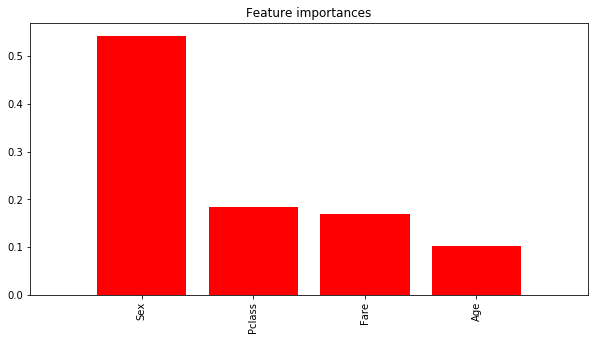

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plot the feature importances of the forest
plt.figure(figsize=(10,5))
plt.title("Feature importances")
plt.bar(range(marvin_dataset["X_train"].shape[1]), importances[indices], color="r",  align="center")

stats_order = [params["pred_cols"][x] for x in indices]

plt.xticks(range(marvin_dataset['X_train'].shape[1]), stats_order, rotation='vertical')
plt.xlim([-1, marvin_dataset['X_train'].shape[1]])
plt.show()

# Prediction Preparator

In [33]:
# put this values in engine.messages to be used as dryrun samples
# age, class, sex
# reminder: 'male': 1, 'female': 0
input_message = {"Age": 50, "Pclass": 3, "Sex": 0, "Fare": 5}

In [34]:
# Given the input: input_message = {"age": 50, "class": 3, "sex": 0}
# Transform the message into a correctly ordered list for the model

key_order = {"Age":0, "Pclass":1, "Sex":2, "Fare":3}
input_message = [input_message[i] for i in sorted(input_message, key=key_order.__getitem__)]

# Predictor

In [35]:
final_prediction = {
    "prediction_rf": marvin_model['rf'].predict([input_message])[0],
    "prediction_svm": marvin_model['svm'].predict([input_message])[0]
}

print(final_prediction)

{'prediction_svm': 1, 'prediction_rf': 0}


# Sample Application

In [45]:
# Take all of the entries in the test dataset and make predictions for them
passengers = marvin_dataset["X_test"].to_dict(orient='records')
for passenger in passengers[0:5]:
    
    # Prediction Preparator
    key_order = {"Age":0, "Pclass":1, "Sex":2, "Fare":3}
    input_message = [passenger[i] for i in sorted(passenger, key=key_order.__getitem__)]
    
    final_prediction = {
    "prediction_rf": marvin_model['rf'].predict([input_message])[0],
    "prediction_svm": marvin_model['svm'].predict([input_message])[0]
    }

    print("Passenger Information: {0}\nPrediction: {1}\n".format(passenger, final_prediction))

Passenger Information: {'Fare': 7.8292000000000002, 'Age': 34.5, 'Pclass': 3.0, 'Sex': 1.0}
Prediction: {'prediction_svm': 0, 'prediction_rf': 0}

Passenger Information: {'Fare': 7.0, 'Age': 47.0, 'Pclass': 3.0, 'Sex': 0.0}
Prediction: {'prediction_svm': 1, 'prediction_rf': 0}

Passenger Information: {'Fare': 9.6875, 'Age': 62.0, 'Pclass': 2.0, 'Sex': 1.0}
Prediction: {'prediction_svm': 0, 'prediction_rf': 0}

Passenger Information: {'Fare': 8.6624999999999996, 'Age': 27.0, 'Pclass': 3.0, 'Sex': 1.0}
Prediction: {'prediction_svm': 0, 'prediction_rf': 0}

Passenger Information: {'Fare': 12.2875, 'Age': 22.0, 'Pclass': 3.0, 'Sex': 0.0}
Prediction: {'prediction_svm': 1, 'prediction_rf': 1}

